# Solver Options

In previous tutorials, we've demonstrated how you can set up an optimization problem using `aerosandbox.Opti()`, and you can solve them by calling `sol = opti.solve()`.

There are several flags that you can use with `sol = opti.solve()`, and here we'll discuss a few.

## Silent Solving

By default, we pipe all IPOPT output to the console so that you have a good idea of how optimization is progressing. However, in some cases (for example, when doing parametric sweeps), you may not want to clutter your console. To make IPOPT quieter, you have a few options.

First, let's write a problem we can solve:

In [74]:
import aerosandbox as asb
import aerosandbox.numpy as np

def setup_problem() -> asb.Opti:
    import aerosandbox as asb
    import aerosandbox.numpy as np

    opti = asb.Opti()

    x = opti.variable(init_guess=1)
    y = opti.variable(init_guess=1)

    opti.subject_to([
        y > x,
        y > -x,
    ])

    opti.minimize(y)

    return opti

Now, let's show a few solver options. Our normal solve looks like:

In [75]:
opti = setup_problem()
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

To silence IPOPT, pass in the `verbose=False` keyword argument:

In [76]:
opti = setup_problem()
sol = opti.solve(verbose=False)

Now, our problem has solved with no printed output.

## Maximum Iterations

We can also set a maximum number of iterations, after which the optimization will automatically fail. This is useful if you're running sweeps, and you want to give up on a point after a certain amount of computational effort.

By default, the maximum number of iterations is set to 3000 - because IPOPT scales *excellently* to high-dimensional and highly-nonconvex problems, you should basically never hit this limit (unless, for example, your problem is exceedingly poorly scaled - see the tutorial on Problem Scaling.)

Let's demonstrate what it looks like if we force IPOPT to fail out:

In [77]:
opti = setup_problem()
try:
    sol = opti.solve(max_iter=2)
except RuntimeError as e:
    print(e)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

So, it errors out as desired.

## Callbacks

Let's say you want to implement a callback while you solve.

What's a callback? It's a function that gets called before every iteration of the optimization solve.

Honestly, optimization with AeroSandbox is typically so fast that it's not worth implementing callbacks. However, sometimes it's interesting to look at the path the optimizer took in order to find the optimum, and we can log the path of the optimizer by using a callback at each iteration.

Let's implement a callback to look at the path taken in solving the 2D Rosenbrock problem:

In [78]:
opti = asb.Opti()

x = opti.variable(init_guess=0)
y = opti.variable(init_guess=1)

def rosenbrock(x, y):
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

opti.minimize(rosenbrock(x, y))

x_iter = [] # The value of x at every iteration
y_iter = [] # The value of y at every iteration

def log_values(iteration_number):
    print(f"Logging optimizer state at iteration {iteration_number}...")
    x_iter.append(opti.debug.value(x))
    y_iter.append(opti.debug.value(y))

sol = opti.solve(
    callback=log_values
)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

Logging optimizer state at iteration 0...
iter    objective    inf_pr   inf_du lg(mu)  

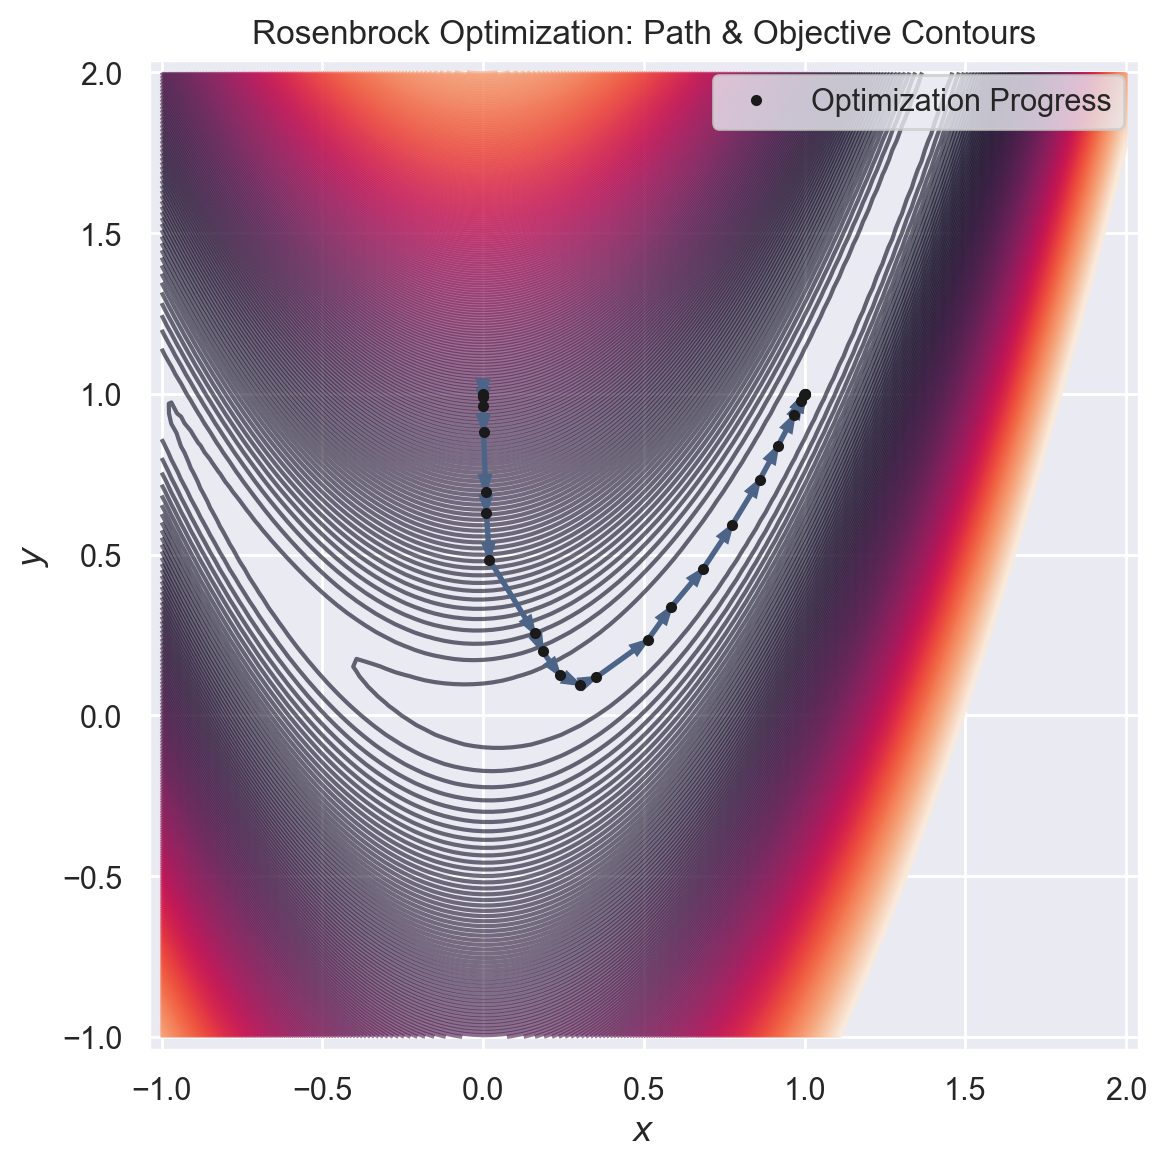

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette("husl"))

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
plt.plot(x_iter, y_iter, ".k", zorder=5, label="Optimization Progress")
for i in range(len(x_iter) - 1):
    plt.arrow(
        x_iter[i],
        y_iter[i],
        x_iter[i+1] - x_iter[i],
        y_iter[i+1] - y_iter[i],
        color="#4c6487",
        width=0.008,
        head_width=0.035,
        length_includes_head = True,
        zorder = 4
    )
X, Y = np.meshgrid(
    np.linspace(-1, 2, 100),
    np.linspace(-1, 2, 100)
)
Z = rosenbrock(X, Y)
plt.contour(X, Y, Z,
            levels = np.arange(0, 500, 2),
            # levels = np.logspace(-2, 3, 100),
            alpha = 0.6,
            zorder=3,
            )
plt.axis('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"Rosenbrock Optimization: Path & Objective Contours")
plt.tight_layout()
plt.legend()
plt.show()

Cool! The optimizer quickly finds the valley and then proceeds to find the deepest point of that valley.

There are other options that you can use with `sol = opti.solve()`, but those are all the ones we'll cover here. Look inside the code for `Opti.solve()` for more info and examples!